# VGG
使用块的网络。一个`VGG块`的核心架构由一些卷积层和一个最大池化层构成。

## VGG块的函数实现

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1)) # 不改变original size
        layers.append(nn.ReLU()) # 激活函数使用ReLu
        
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

## VGG11结构
八个卷积层和三个线性全连接层。

每一次输出的通道数翻倍。

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [8]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5), # 7*7的由来：五层每一次池化导致高宽减半
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [9]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [10]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

## 训练模型

training on cpu


/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/cs224

KeyboardInterrupt: 

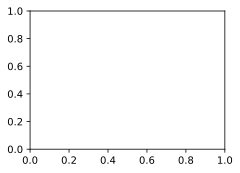

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())